<!-- dom:TITLE: Guassian Process Regression by Example -->
# Guassian Process Regression by Example
<!-- dom:AUTHOR: Landman Bester -->
<!-- Author: --> **Landman Bester**

Date: **TODAY**

**Summary.** A very quick and hands on intro to GPR.











# Introducing the Gaussian Process Regression (GPR) problem
In its most basic form a Gaussian process (GP) is a collection of random variables, any finite subset of which have a joint Gaussian distribution \[[rasmussen2006gp]](#rasmussen2006gp). A GP can be completely characterised by specifying its mean $m(\mathbf{x})$ and covariance $k(\mathbf{x},\tilde{\mathbf{x}})$ functions. The mean and covariance function of a real process $f(\mathbf{x})$ are defined by

$$
\begin{align*}
m(\mathbf{x}) &= \mathbb{E}_{\mathcal{N}}[f(\mathbf{x})], \\
k(\mathbf{x},\tilde{\mathbf{x}}) &= \mathbb{E}_{\mathcal{N}}[(f(\mathbf{x}) - m(\mathbf{x}))(f(\tilde{\mathbf{x}}) - m(\tilde{\mathbf{x}}))].
\end{align*}
$$

This is conveniently abbreviated using the notation $f(\mathbf{x}) \sim \mathcal{G}\mathcal{P}(m(\mathbf{x}),k(\mathbf{x},\tilde{\mathbf{x}}))$. Note that the notation $\mathbb{E}_{\mathcal{N}}[\cdot]$ is used to denote the expectation value with respect to a Gaussian distribution. Restricting to 1D input variables for now, we may replace $\mathbf{x}$ by $x$ in the above equations. 

Suppose that we want to perform GPR on a data set

<!-- Equation labels as ordinary links -->
<div id="Eq.1"></div>

$$
\begin{equation}
\mathcal{D}_y = \left[x_i, y_i, \delta y_i \right] \label{Eq.1} \tag{1}
\end{equation}
$$

where the $y_i$ are observations of a function, $f(x)$ say, at the locations $x_i$ and $\delta y_i$ are the uncertainties on these observations. In other words we have

<!-- Equation labels as ordinary links -->
<div id="Eq.2"></div>

$$
\begin{equation}
y_i = f(x_i) + \delta y_i, \label{Eq.2} \tag{2}
\end{equation}
$$

The GPR problem consists of inferring the underlying function $f(x)$ from the data. GPR is useful for numerous other applications eg. differentiating data, incorporating explicit basis function. However, before delving into the details, let's review some topics from our statistics bible.

# Probability and Bayes law
The joint probability of a finite dimensional vector $\mathbf{y} = [y_1,y_2,\cdots,y_D]$ of dimension $D$ is denoted $p(\mathbf{y})$. The set $\mathbf{y}$ can be partitioned into a number of disjoint subsets, each playing a different part in the model. This simple operation is at the heart of Bayesian modelling. To illustrate the general idea we partition $\mathbf{y}$ into two disjoint subsets $\mathbf{y}_A$ and $\mathbf{y}_B$ and write their joint probability distribution as $p(\mathbf{y}_A,\mathbf{y}_B)$. The marginal probability of $\mathbf{y}_A$ is defined as

<!-- Equation labels as ordinary links -->
<div id="Eq.3"></div>

$$
\begin{equation}
p(\mathbf{y}_A) := \int p(\mathbf{y}_A,\mathbf{y}_B) d \mathbf{y}_B. \label{Eq.3} \tag{3}
\end{equation}
$$

The marginal probability expresses the joint probability of $\mathbf{y}_A$ regardless of the possible values that $\mathbf{y}_B$ can take. If the parameters are independent the act of marginalisation has no effect. In that case the joint probability is simply the product of the marginals i.e. $p(\mathbf{y}_A,\mathbf{y}_B) = p(\mathbf{y}_A)p(\mathbf{y}_B)$. Another concept that plays an important role in Bayesian modelling is the conditional probability. The joint probability distribution of $\mathbf{y}_A$ conditioned on the values of $\mathbf{y}_B$ is defined as

<!-- Equation labels as ordinary links -->
<div id="Eq.4"></div>

$$
\begin{equation}
p(\mathbf{y}_A |\mathbf{y}_B) := \frac{p(\mathbf{y}_A,\mathbf{y}_B)}{p(\mathbf{y}_B)} \label{Eq.4} \tag{4}
\end{equation}
$$

Whereas ([Eq.3](#Eq.3)) allows us to describe the joint probability distribution of $\mathbf{y}_A$ independently of $\mathbf{y}_B$, ([Eq.4](#Eq.4)) describes the joint probability of $\mathbf{y}_A$ given the values (or distributions) of $\mathbf{y}_B = Y_B$. If $\mathbf{y}_A$ and $\mathbf{y}_B$ are independent then these two operations are equivalent and the conditional and marginal distributions will be identical. Note that we can combine the two definitions ([Eq.3](#Eq.3)) and ([Eq.4](#Eq.4)) to rewrite the marginalised probability as

<!-- Equation labels as ordinary links -->
<div id="Eq.5"></div>

$$
\begin{equation}
p(\mathbf{y}_A) = \int p(\mathbf{y}_A | \mathbf{y}_B) p(\mathbf{y}_B) d \mathbf{y}_B. \label{Eq.5} \tag{5}
\end{equation}
$$

Bayes' theorem, which can be established from the fact that $p(\mathbf{y}_A,\mathbf{y}_B) = p(\mathbf{y}_B,\mathbf{y}_A)$ and the definition of conditional probability, states that

<!-- Equation labels as ordinary links -->
<div id="Eq.6"></div>

$$
\begin{equation}
p(\mathbf{y}_A |\mathbf{y}_B) = \frac{p(\mathbf{y}_B | \mathbf{y}_A)p(\mathbf{y}_A)}{p(\mathbf{y}_B)} = \frac{\mbox{likelihood} \times \mbox{prior}}{\mbox{marginal likelihood}}. \label{Eq.6} \tag{6}
\end{equation}
$$

In the Bayesian interpretation we identify $p(\mathbf{y}_B | \mathbf{y}_A)$ as the likelihood, $p(\mathbf{y}_A)$ as the prior, $p(\mathbf{y}_B)$ as the evidence or marginal likelihood and $p(\mathbf{y}_A |\mathbf{y}_B)$ as the posterior probability. We will find it useful to review the properties of the multivariate Gaussian distribution.

# The multivariate Gaussian distribution
Recall that a jointly Gaussian random vector $\mathbf{y} = [y_1,y_2,\cdots,y_n]$ has probability density given by

<!-- Equation labels as ordinary links -->
<div id="Eq.7"></div>

$$
\begin{equation}
p(\mathbf{y|\bar{y}},\Sigma_y) = (2\pi)^{-n/2} |\Sigma_y|^{-1/2} \exp \left(-\frac{1}{2}(\mathbf{y} - \bar{\mathbf{y}})^T \Sigma^{-1}_y(\mathbf{y} - \bar{\mathbf{y}})\right), \label{Eq.7} \tag{7}
\end{equation}
$$

where $\bar{\mathbf{y}}$ is its mean vector (of length $n$) and $\Sigma$ its (symmetric, positive definite) covariance matrix (of size $n \times n$). This is abbreviated using the notation $\mathbf{y} \sim \mathcal{N}(\bar{\mathbf{y}},\Sigma_y)$. If we partition $\mathbf{y}$ into two disjoint subsets as $\mathbf{y} = [\mathbf{y}_A,\mathbf{y}_B]$, then

<!-- Equation labels as ordinary links -->
<div id="Eq.8"></div>

$$
\begin{equation}
\left[ \begin{array}{c}\mathbf{y}_A \\ \mathbf{y}_B \end{array} \right] \sim \mathcal{N}\left(\left[ \begin{array}{c}\bar{\mathbf{y}}_A \\ \bar{\mathbf{y}}_B \end{array}\right], \left[ \begin{array}{cc} \Sigma_A & C \\ C^T & \Sigma_B \end{array} \right] \right),  \label{Eq.8} \tag{8}
\end{equation}
$$

where $\Sigma_A$ is the covariance matrix of $\mathbf{y}_A$, $\Sigma_B$ is the covariance matrix of $\mathbf{y}_B$ and $C$ expresses the covariance between them. The marginal ([Eq.3](#Eq.3)) and conditional ([Eq.4](#Eq.4)) distributions are given by

<!-- Equation labels as ordinary links -->
<div id="Eq.9"></div>

$$
\begin{equation}
\mathbf{y}_A \sim \mathcal{N}(\bar{\mathbf{y}}_A,\Sigma_A), \label{Eq.9} \tag{9}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="Eq.10"></div>

$$
\begin{equation} 
\mathbf{y}_A|\mathbf{y}_B \sim \mathcal{N}\left(\bar{\mathbf{y}}_A + C\Sigma_B^{-1}(\mathbf{y}_B-\bar{\mathbf{y}}_B), \Sigma_A - C\Sigma_B^{-1}C^T\right). \label{Eq.10} \tag{10}
\end{equation}
$$

The product of two Gaussians gives another (un-normalized) Gaussian

<!-- Equation labels as ordinary links -->
<div id="Eq.11"></div>

$$
\begin{equation}
\mathcal{N}(\mathbf{x|a},A)\mathcal{N}(\mathbf{x|b},B) = Z^{-1}\mathcal{N}(\mathbf{x|c},C), \label{Eq.11} \tag{11}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="Eq.12"></div>

$$
\begin{equation} 
\mbox{where} ~~ \mathbf{c} = C(A^{-1}\mathbf{a} + B^{-1}\mathbf{b}) ~~ \mbox{and} ~~ C = (A^{-1} + B^{-1})^{-1}, \label{Eq.12} \tag{12}
\end{equation}
$$

and the normalization constant also looks like a Gaussian

<!-- Equation labels as ordinary links -->
<div id="Eq.13"></div>

$$
\begin{equation}
Z^{-1} = (2\pi)^{D/2}|A+B|^{-1/2} \exp \left(-\frac{1}{2}(\mathbf{a - b})^T(A+B)^{-1}(\mathbf{a-b})\right). \label{Eq.13} \tag{13}
\end{equation}
$$

This is just about everything we need to perform Gaussian process regression. 

# Setting up the problem
The Gaussian process regression (GPR) problem aims to reconstruct the posterior distribution of a function, $f$ say, from a number of discrete observations as in ([Eq.1](#Eq.1)). As a simple illustration, suppose we seek the underlying function $f(x)$ in ([Eq.2](#Eq.2)). Denoting the points at which the function is to be reconstructed by $x_p$ (with a subscript $p$ for predict), means that the finite collection of random variables whose joint Gaussian distribution we want to infer from the data is $f_p = f(x_p)$. This is achieved by specifying the joint distribution between the observations and the random variables $f_p$. Suppose we select a finite subset of function values and partition them as $[Y,f_p]$, where $Y = [y_1,y_2,\cdots,y_n]$ is a numerical vector formed by concatenating all the observations $y_i$ of the function. Under a GP prior, the joint distribution of the data and the $f_p$ is a Gaussian distribution of the form

<!-- Equation labels as ordinary links -->
<div id="Eq.14"></div>

$$
\begin{equation}
\left[ \begin{array}{c} Y \\ f_p \end{array}\right] \sim  \mathcal{N}\left( \left[ \begin{array}{c} m(X) \\ m(X_p) \end{array}\right], \left[ \begin{array}{cc}
k(X,X) + \Sigma_y & k(X,X_p) \\ k(X_p,X) & k(X_p,X_p) \end{array}  \right] \right), \label{Eq.14} \tag{14}
\end{equation}
$$

where $X = [x_1,x_2,\cdots,x_n]$ is the vector formed by concatenating all the inputs and $X_p$ is the vector formed by concatenating all the points at which we wish to reconstruct the function $x_p$. For brevity we sometimes omit the arguments of the mean and covariance functions and refer, respectively, to $M = m(X)$ and $K = k(X,X)$ as the vector and matrix formed by evaluating the mean and covariance functions at the points $X$, and similarly $M_p = m(X_p), K_p = k(X,X_p), K_p^T = k(X_p,X)$ and $K_{pp} = k(X_p,X_p)$.

The "trick" employed in GPR is to specify a sufficiently generous prior distribution and then restrict the $f_p$ to be compatible with the observations by using ([Eq.10](#Eq.10)) to form the conditional distribution i.e.

<!-- Equation labels as ordinary links -->
<div id="Eq.15"></div>

$$
\begin{equation}
f_p| X,Y,X_p \sim \mathcal{N}\left(\bar{f}_p, \mbox{cov}(f_p)\right), ~~ \mbox{where} \label{Eq.15} \tag{15} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="Eq.16"></div>

$$
\begin{equation} 
\bar{f}_p = M_p + K_p^T K_y^{-1} \left(Y - M\right), \label{Eq.16} \tag{16} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="Eq.17"></div>

$$
\begin{equation} 
\mbox{cov}(f_p) = K_{pp} - K_p^T K_y^{-1}K_p. ~~ \label{Eq.17} \tag{17}
\end{equation}
$$

When performing GPR everything hinges on the form of the prior distribution and the quality of the data. If we specify an incorrect prior from the outset then GPR will perform poorly regardless of the quality of the data. Note that, as evidenced by equation ([Eq.17](#Eq.17)), the form of the prior mean function doesn't enter into the computation of the posterior covariance matrix at all. Its role is basically to zero the data. It can significantly alter the results in regions where the data are sparse. In particular, in absence of a prior mean function (i.e. $m(\cdot) \equiv 0$), it is not recommended to try and predict values of the function beyond, or near, the edges of the data set. This is because in such regions the contribution of the prior to the likelihood will dominate and therefore tend to bias the predictions towards zero. These "edge effects" are unavoidable without using a mean function. Note that the prior will also dominate the likelihood in regions where the data are sparse compared to the length scale of the posterior covariance function. It is easiest to illustrate this with an example. One popular covariance function is the squared exponential, which takes the form

<!-- Equation labels as ordinary links -->
<div id="Eq.18"></div>

$$
\begin{equation}
k(x,\tilde{x}) = \sigma_f^2\exp\left(-\frac{(x-\tilde{x})^2}{2l^2}\right). \label{Eq.18} \tag{18}
\end{equation}
$$

This is an example of a stationary covariance function i.e. it only depends on the difference $x - \tilde{x}$. Note that we do not explicitly indicate the functional dependence on the parameters $\sigma_f$ and $l$, which allow for more flexibility in the prior. Parameters that are required in the specification of the prior (here $\sigma_f$ and $l$) are called hyperparameters and we will denote them collectively by $\theta$. With the form ([Eq.18](#Eq.18)), the roles of $l$ and $\sigma_f$ can be interpreted as follows:
* The parameter $l$ is called the length scale. It sets a characteristic length which determines the strength of correlation between function values for a given separation between two points in their domain.

* The parameter $\sigma_f$ is called the signal variance. It constrains the amount by which a function can change for a given $l$ and separation between points in the domain.   

We now come back to the statement made above regarding the role of the mean function when the data are sparse compared to the length scale of the posterior covariance function. In light of ([Eq.18](#Eq.18)), or in fact any stationary covariance function, we now see that input points separated by distances $ >> l$ will convey negligible information about the covariance between the values of the function at these points. However, when sufficient data are available, the form of the mean function is not very important and it is often safe to assume a zero mean function. The form of the covariance function however can be crucial, and so are the means by which we adapt it to the data.

Here $\bar{f}_p = \mathbb{E}_{\mathcal{N}}[f_p|X,y,X_p]$ is the posterior (also called predictive) mean, $\mbox{cov}(f_p)$ the posterior covariance matrix and $K_y = K + \Sigma_y$. Eqns ([Eq.15](#Eq.15)) - ([Eq.17](#Eq.17)) are the key predictive equations for GPR. This remarkably simple procedure can accommodate a very large class of functions. The properties of these functions are determined by the choice of prior mean and covariance functions. After all of that it might be time for an example.

In [1]:
%matplotlib inline

# Import required modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact

# Create function to compute the differences x[i] - x[j]
def ij_diff(x,xtilde):
    XX = np.zeros([x.size,xtilde.size])
    for i in xrange(x.size):
        for j in xrange(xtilde.size):
            XX[i,j] = x[i] - xtilde[j]
    return XX

# Specify the form of the covariance function (here we use the squared exponential)
def K(theta,x):
    """
    Covariance function
    """
    return theta[0]**2*np.exp(-x**2/(2*theta[1]**2))

# Create functions to compute the predictive mean and covariance
def meanf(theta,XX,XXp,y,SIGMAy):
    """
    Posterior mean function
    """
    Kp = K(theta,XXp)
    Ky = K(theta,XX) + SIGMAy
    return np.dot(Kp.T,np.linalg.solve(Ky,y))

def covf(theta,XX,XXp,XXpp, SIGMAy):
    """
    Posterior covariance matrix
    """
    Kp = K(theta,XXp)
    Kpp = K(theta,XXpp)
    Ky = K(theta,XX) + SIGMAy
    L = np.linalg.cholesky(Ky)
    Linv = np.linalg.inv(L)
    LinvKp = np.dot(Linv,Kp)
    return Kpp - np.dot(LinvKp.T,LinvKp)

/home/landman/virtualenvmts/GPenv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Ignoring for now the terrible choice of function name K (chosen for notational clarity), lets quickly have a look at how to use the above functions to perform GPR.

In [2]:
def inter_GPR(sigma_f,l,x=None,y=None,SIGMAy=None,xp=None):
    """
    A function which performs GPR on a dataset D = [x,y,sy] and predicts the mean and covariances
    at locations xp.
    """
    # Set vector of hypers
    theta = np.array([sigma_f,l])
    print 'sigma_f = ', sigma_f, 'l = ', l

    # Get matrix of differences
    XX = ij_diff(x,x)
    XXp = ij_diff(x,xp)
    XXpp = ij_diff(xp,xp)
 
    # Get the predictive mean
    fbar = meanf(theta,XX,XXp,y,SIGMAy)

    # Get the predictive covariance matrix
    fcov = covf(theta,XX,XXp,XXpp,SIGMAy)

    # Get the standard deviation at each target xp (note the variance comes from the diagonal of the cov matrix)
    fstd = np.sqrt(np.diag(fcov))

    # Plot the result
    plt.figure('x',figsize=(15, 6))
    plt.plot(xp,fbar,'k',label=r'$\bar{f}$')
    plt.errorbar(x,y,sy,fmt='xr',label=r'$Data$')
    plt.fill_between(xp, fbar + fstd, fbar - fstd, facecolor='blue', edgecolor='blue')
    plt.xlabel(r'$x$',fontsize=18)
    plt.ylabel(r'$f(x)$',fontsize=18)
    plt.legend()

Ok now lets simulate some data and perform GPR.

sigma_f =  1.0 l =  1.0


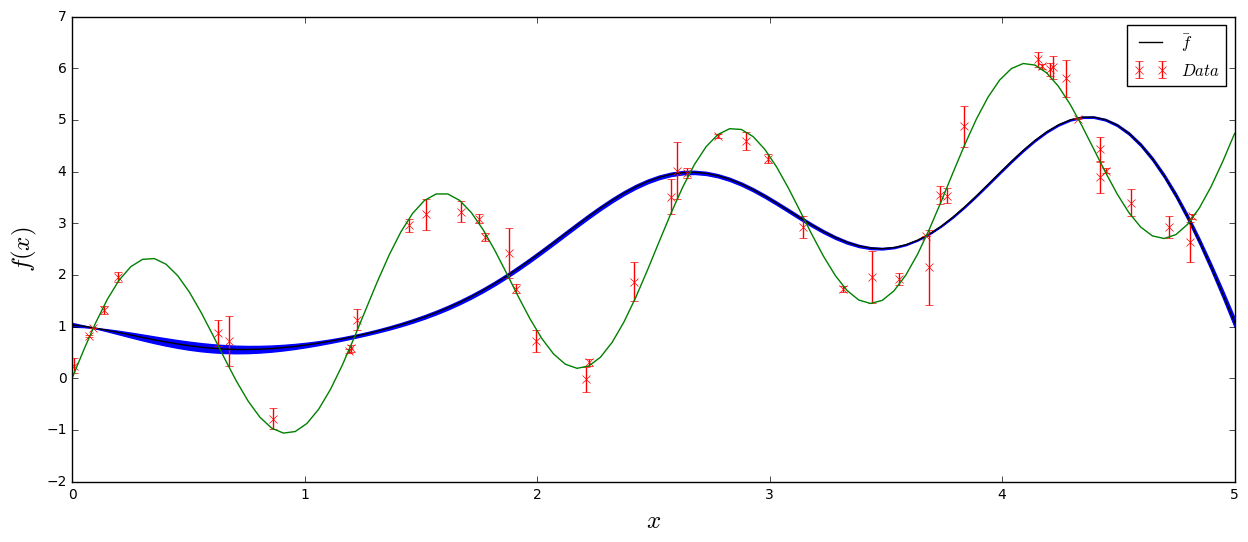

In [3]:
N = 50  # The number of data points
xmin = 0.0  # Minimum value of x
xmax = 5.0  # Maximum value of x

# Simulate N data points at locations uniformly distributed between xmin and xmax
xi = xmin + xmax*np.random.random(N)

# Set the uncertainties of the data
sig_data = 0.25
sy = sig_data*np.random.randn(N)

# Choose model function as linear + sinusoidal function
def fx(x):
    return x + 2*np.sin(5*x)

# Generate data by adding noise to the model 
yi = fx(xi) + sy

# Choose some points at which to reconstruct the function
Np = 100 #Number of points at which to reconstruct the function
xpmin = 0
xpmax = 5
xp = np.linspace(xpmin,xpmax,Np) 

# Choose some values for the hyperparameters (arbitrary for now)
l = 1.0
sigma_f = 1.0

# Perform the regression
inter_GPR(sigma_f,l,xi,yi,np.diag(sy**2),xp)

# Plot model for comparison
yp = fx(xp)

plt.plot(xp,yp,'g',label=r'$Model$')

Let's see what's going on here. Note that the data are shown with red error bars, the posterior mean in black and the model function in green. The blue shaded region shows the 1-$\sigma$ confidence interval as determined from the posterior covariance matrix. The output might seem rather bizzarre at first, why is the predictive mean so different from the model? Even more worrysome from a Bayesian point of view, why is the model not contained within the 1-$\sigma$ confidence interval? The answer is simple and relates the arbitrarily chosen values for the hyperparameters $\sigma_f$ and $l$. With these values the prior is clearly miss-specified. Below is a little interactive demo which illustrates how the prediction varies as a function of these two hyperparameters. Use the widgest to adjust the values of $\sigma_f$ and $l$ and inspect what happens to the output.

In [4]:
interact(lambda sigma_f,l:inter_GPR(sigma_f=sigma_f,l=l,x=xi,y=yi,SIGMAy=np.diag(sy**2),xp=xp),
                sigma_f=(1e-3,5,0.1),l=(1e-3,5,0.05)) and None

From this it should be clear that the the reconstruction depends quite strongly on the assumed values of the hyperparameters. One of the benefits to using GPR (as apposed to the Wiener filter for example) is that the formalism allows us to learn what the optimal values for the hyperparameters are. This is done by maximising the marginal likelihood w.r.t. the hyperparameters. 

# Marginal likelihood
The hyperparameters are not arbitrary and must be learnt from the data. This is where Bayes' theorem comes in handy. In the GPR context it takes the following form

$$
p(f|Y,X) = \frac{p(Y|f,X)p(f|X)}{p(Y|X)}.
$$

Here the likelihood $p(Y|f,X)$ is given by

$$
p(Y|f,X) =  (2\pi)^{-\frac{n}{2}}\Sigma_y^{-\frac{1}{2}}\exp\left(-\frac{(Y - f)^T\Sigma_y^{-1}(Y - f)}{2}\right).
$$

The prior is also a Gaussian and, with the understanding that there is an implicit dependence on the choice of mean and covariance function, can be written as

$$
p(f|X) = (2\pi)^{-\frac{n}{2}}K^{-\frac{1}{2}}\exp\left(-\frac{(f - M)^TK^{-1}(f - M)}{2}\right).
$$

Thus the marginal likelihood associated with GPR is given by the integral

$$
p(Y|X) = \int p(Y|f,X)p(f|X) \mbox{d} f.
$$

We could compute this integral directly or we could simply note that $Y \sim \mathcal{N}\left(0,K + \Sigma_y\right)$. Both routes give the following form for the marginal log-likelihood

<!-- Equation labels as ordinary links -->
<div id="Eq.19"></div>

$$
\begin{equation}
\log(p(Y|X,\theta)) = -\frac{1}{2}Y^T K_y^{-1} Y - \frac{1}{2} \log|K_y| - \frac{n}{2}\log(2\pi). \label{Eq.19} \tag{19}
\end{equation}
$$

This is a straightforward bounded optimisation problem. We can use one of scipy's built in solvers as shown in the code snippet below.

In [4]:
import scipy.optimize as opt

def logp(theta,XX,y,SIGMAy,n):
    """
    The negative log (marginal) likelihood (the function to be optimised)
    """
    Ky = K(theta,XX) + SIGMAy
    return np.dot(y.T,np.linalg.solve(Ky,y))/2.0 + np.linalg.slogdet(Ky)[1]/2.0 + n*np.log(2*np.pi)/2.0

#Set initial hypers and optimize
theta = np.array([1.0,0.5])

#Set bounds for hypers (they must be strictly positive)
bnds = ((1.0e-5, None), (1.0e-5, None))

XX = ij_diff(xi,xi)
SIGMAy = np.diag(sy**2)

#Optimise marginal likelihood w.r.t. hypers
thetap = opt.minimize(logp,theta,args=(XX,yi,SIGMAy,N),method='SLSQP',bounds=bnds)

#Get optimised value
theta = thetap.x
if thetap.success:
    print "Great success! The marginal likelihood reaches a maximum at sigma_f = ", theta[0]," and l = ",theta[1]
else:
    print "Something went wrong with the optimisation. Try a different starting point maybe?"

Great success! The marginal likelihood reaches a maximum at sigma_f =  3.41907185957  and l =  0.458580948725


Lets go back and see what the reconstruction looks like if we plug in these values.

sigma_f =  3.41907185957 l =  0.458580948725


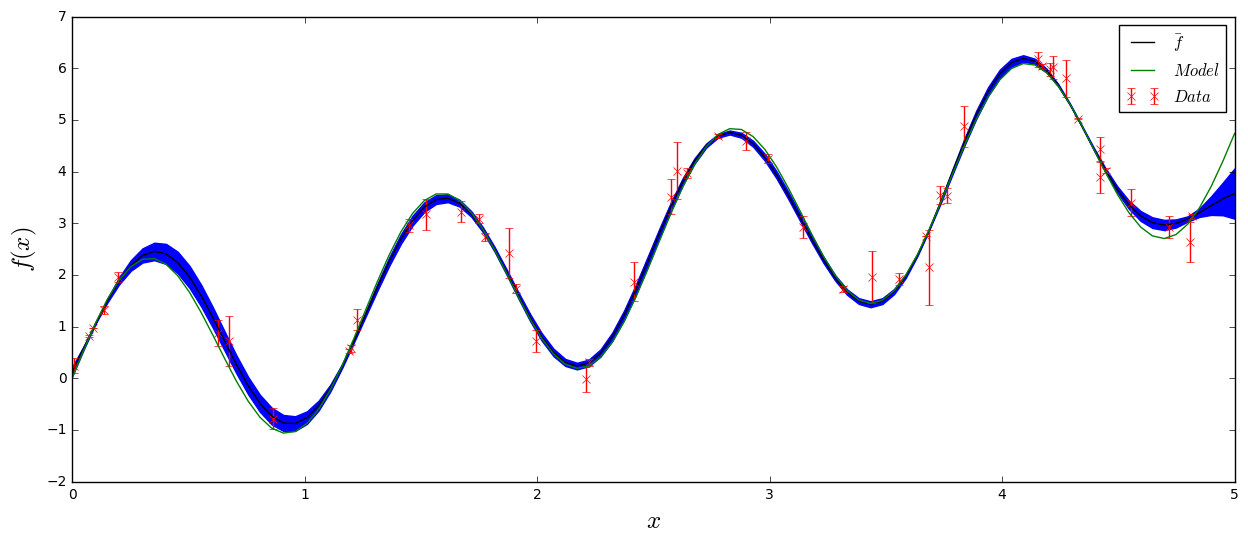

In [6]:
# Choose some values for the hyperparameters (arbitrary for now)
plt.close('all')

l = theta[1]
sigma_f = theta[0]

# Perform the regression
inter_GPR(sigma_f,l,xi,yi,np.diag(sy**2),xp)

# Plot model for comparison
yp = fx(xp)

plt.plot(xp,yp,'g',label=r'$Model$')
plt.legend()